<a href="https://colab.research.google.com/github/youngG124/gitbashtest/blob/master/pix2pixShinyeong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
import glob
import matplotlib.pyplot as plt
import cv2

In [12]:
origin_dir = '/content/drive/MyDrive/Colab Notebooks/night/color'
gray_dir = '/content/drive/MyDrive/Colab Notebooks/night/gray'
resized_dir = '/content/drive/MyDrive/Colab Notebooks/night/resized'

print('number of files in "original" folder:', len(os.listdir(origin_dir)))
print('number of files in "resized" folder:', len(os.listdir(resized_dir)))
print('number of files in "gray" folder:', len(os.listdir(gray_dir)))

number of files in "original" folder: 33
number of files in "resized" folder: 33
number of files in "gray" folder: 33


In [13]:
origin_files = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/night/color/' + '*'))
resized_files = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/night/resized/' + '*'))
gray_files = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/night/gray/' + '*'))

In [14]:
print(origin_files[:2])

print(resized_files[:2])

print(gray_files[:2])

['/content/drive/MyDrive/Colab Notebooks/night/color/1.jpg', '/content/drive/MyDrive/Colab Notebooks/night/color/10.jpg']
['/content/drive/MyDrive/Colab Notebooks/night/resized/1.jpg', '/content/drive/MyDrive/Colab Notebooks/night/resized/10.jpg']
['/content/drive/MyDrive/Colab Notebooks/night/gray/gray_night1.jpg', '/content/drive/MyDrive/Colab Notebooks/night/gray/gray_night10.jpg']


In [15]:
# cv2 모듈로 이미지 읽는 함수 정의
def read_img(file_path):
    img_arr = cv2.imread(file_path)
    return cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

/content/drive/MyDrive/Colab Notebooks/night/color/1.jpg
(326, 500, 3)


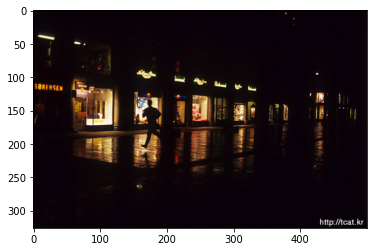

In [18]:
img_arr = read_img(origin_files[0])

# 파일 경로 출력
print(origin_files[0])

# 이미지 크기 출력
print(img_arr.shape)

# 이미지 시각화
plt.imshow(img_arr)

/content/drive/MyDrive/Colab Notebooks/night/resized/1.jpg
(256, 256, 3)


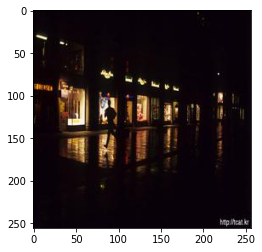

In [19]:
img_arr = read_img(resized_files[0])

# 파일 경로 출력
print(resized_files[0])

# 이미지 크기 출력
print(img_arr.shape)

# 이미지 시각화
plt.imshow(img_arr)

In [20]:
import numpy as np

def get_mean_and_std(files):
    # global mean 구하기
    global_mean = 0
    global_var = 0

    for img in files:
        img_arr = read_img(img) / 255
        global_mean += img_arr.reshape(-1, 3).mean(axis=0)

    global_mean /= len(files)

    # global std 구하기
    for img in files:
        img_arr = read_img(img) / 255
        global_var += ((img_arr.reshape(-1, 3) - global_mean)**2).mean(axis=0)
    
    global_var /= len(files)
    global_std = np.sqrt(global_var)

    return global_mean, global_std

In [21]:
# 컬러 이미지 평균, 표준편차
color_mean, color_std = get_mean_and_std(resized_files)
color_mean, color_std

(array([0.18241941, 0.15401327, 0.12579991]),
 array([0.20359029, 0.18359755, 0.16529955]))

In [22]:
# 흑백 이미지 평균, 표준편차
gray_mean, gray_std = get_mean_and_std(gray_files)
gray_mean, gray_std

(array([0.15906113, 0.15906113, 0.15906113]),
 array([0.188888, 0.188888, 0.188888]))

In [23]:
import pandas as pd

def get_statistics(arr):
    return pd.DataFrame(arr.reshape(-1, 3), columns=["R", "G", "B"]).describe()

In [24]:
color_img = read_img(resized_files[0]) / 255
gray_img = read_img(gray_files[0]) / 255

In [75]:
get_statistics(color_img)

NameError: ignored

In [ ]:
get_statistics(gray_img)

,R,G,B
count,163000.000000,163000.000000,163000.000000
mean,0.070614,0.070614,0.070614
std,0.147036,0.147036,0.147036
min,0.000000,0.000000,0.000000
25%,0.015686,0.015686,0.015686
50%,0.023529,0.023529,0.023529
75%,0.039216,0.039216,0.039216
max,1.000000,1.000000,1.000000


In [15]:
normalized_color_img = (color_img - color_mean) / color_std
normalized_gray_img = (gray_img - gray_mean) / gray_std

NameError: ignored

In [ ]:
get_statistics(normalized_color_img)

,R,G,B
count,65536.000000,65536.000000,65536.000000
mean,-0.395253,-0.526841,-0.402834
std,0.829348,0.767402,0.597939
min,-0.896012,-0.838863,-0.761042
25%,-0.741916,-0.817504,-0.571250
50%,-0.684130,-0.774785,-0.547526
75%,-0.568557,-0.689346,-0.500078
max,4.015813,4.607832,5.288581


In [14]:
get_statistics(normalized_gray_img)

NameError: ignored

여기까지가 color, resized 데이터 불러와서 정규화하기.


In [76]:
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torch.autograd import Variable

In [77]:
class NightDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, '/content/drive/MyDrive/Colab Notebooks/night/resized/') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, '/content/drive/MyDrive/Colab Notebooks/night/resized/') + "/*.*"))
     
    def __getitem__(self, index):
        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)


In [78]:
root = ''

batch_size = 12
img_height = 256
img_width = 256

In [79]:
color_mean = [0.101950, 0.057286, 0.059212]
color_std = [0.168847, 0.140893, 0.098839]
gray_mean = [ 0.070614,0.070614,0.070614]
gray_std = [0.147036,0.147036,0.147036]

color_transforms_ = [
                     transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
                     transforms.Resize((256,256)),
    transforms.ToTensor(),
                    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

In [80]:
train_loader  = DataLoader(
    NightDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size
)

In [81]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

torch.Size([12, 3, 256, 256]) torch.Size([12, 3, 256, 256])


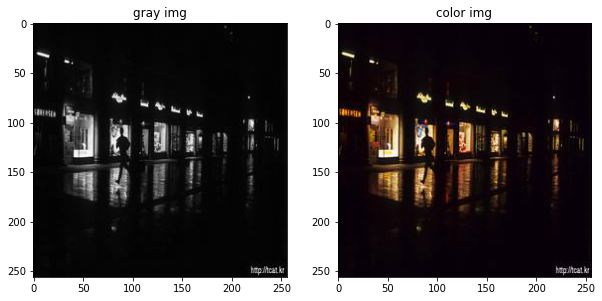

In [82]:
fig = plt.figure(figsize=(10, 5))
rows = 1 
cols = 2

for X in train_loader :

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std)) 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [83]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# U-NET 생성

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [84]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [85]:
n_epochs = 100
dataset_name = "Victorian400"
lr = 0.0002
b1 = 0.5                    # adam: decay of first order momentum of gradient
b2 = 0.999                  # adam: decay of first order momentum of gradient
decay_epoch = 100           # epoch from which to start lr decay
#n_cpu = 8                   # number of cpu threads to use during batch generation
channels = 3                # number of image channels
checkpoint_interval = 20    # interval between model checkpoints

In [86]:
os.makedirs("images/%s/val" % dataset_name, exist_ok=True)
os.makedirs("images/%s/test" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [87]:
def sample_images(epoch, loader, mode):
    imgs = next(iter(loader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)    
    
    gray_img = torchvision.utils.make_grid(gray.data, nrow=6) 
    color_img = torchvision.utils.make_grid(color.data, nrow=6)  
    output_img = torchvision.utils.make_grid(output.data, nrow=6)

    rows = 3
    cols = 1

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(gray_img.cpu(), gray_mean, gray_std)) 
    ax1.set_title('gray')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(color_img.cpu(), color_mean, color_std))
    ax2.set_title('color')  

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(reNormalize(output_img.cpu(), color_mean, color_std))
    ax3.set_title('output')  

    plt.show()
    fig.savefig("images/%s/%s/epoch_%s.png" % (dataset_name, mode, epoch), pad_inches=0)

In [88]:
import torch
torch.cuda.is_available()

True

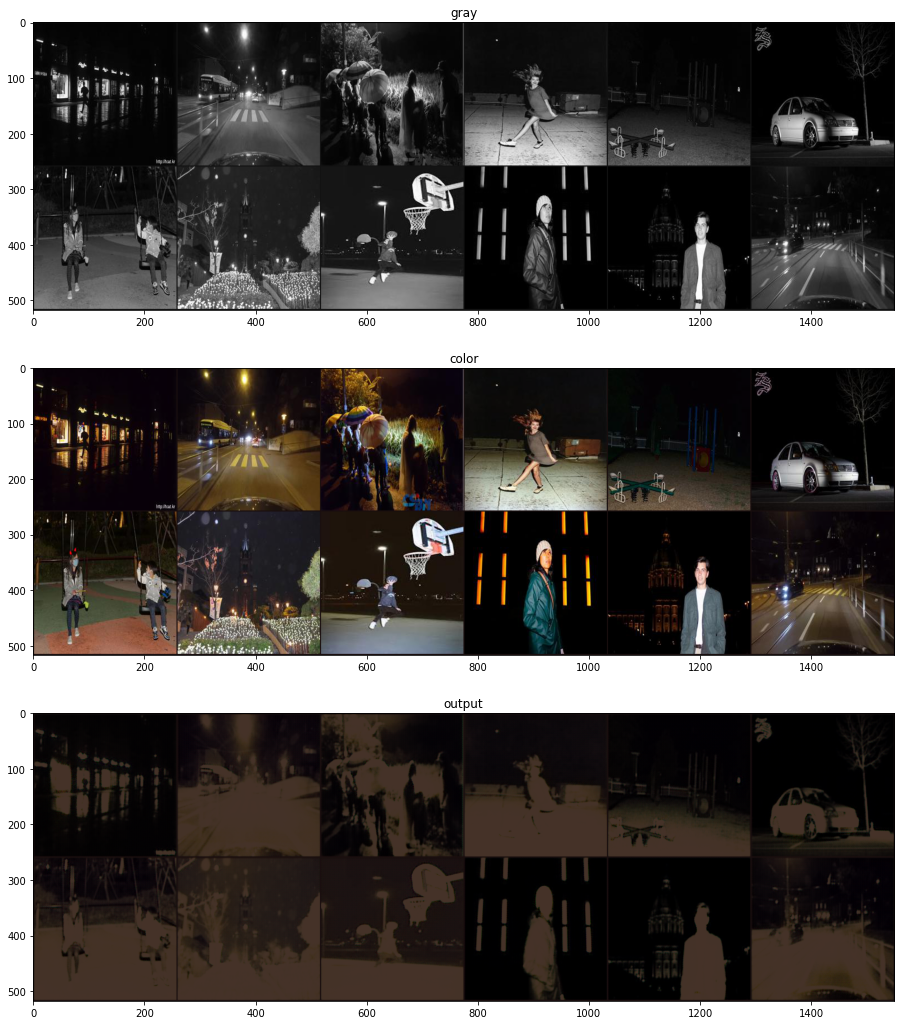

[Epoch 20/100] [Batch 3/3] [D loss: 0.074273] [G loss: 33.365353, pixel: 0.327058, adv: 0.659514] ETA: 0:00:03.601085


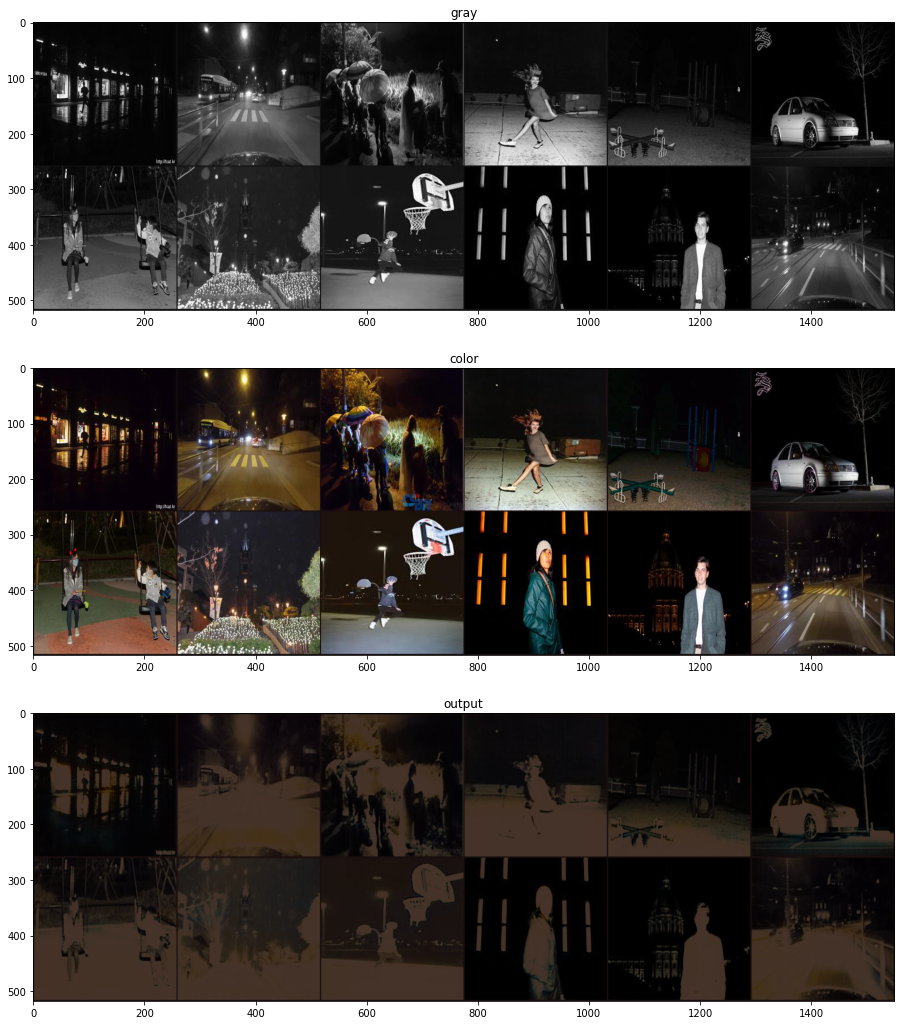

[Epoch 40/100] [Batch 3/3] [D loss: 0.036064] [G loss: 32.328381, pixel: 0.314254, adv: 0.903021] ETA: 0:00:03.610343


KeyboardInterrupt: ignored

In [89]:
# ----------
#  Training
# ----------

for epoch in range(1, n_epochs+1):
    start_time = datetime.datetime.now()
    for i, batch in enumerate(train_loader):

        # Model inputs
        gray = Variable(batch["A"].type(Tensor))
        color = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((gray.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((gray.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        output = generator(gray)
        pred_fake = discriminator(output, gray)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(output, color)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(color, gray)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(output.detach(), gray)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        epoch_time = datetime.datetime.now() - start_time

    if (epoch) % checkpoint_interval == 0:
        fig = plt.figure(figsize=(18, 18))
        sample_images(epoch, train_loader, 'val')

        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" % (epoch, 
                                                                                                    n_epochs, 
                                                                                                    i+1, 
                                                                                                    len(train_loader), 
                                                                                                    loss_D.item(), 
                                                                                                    loss_G.item(), 
                                                                                                    loss_pixel.item(), 
                                                                                                    loss_GAN.item(), 
                                                                                                    epoch_time))
     